In [ ]:
!pip install torch torchvision tqdm scikit-learn matplotlib pillow pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import models, transforms, datasets
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from PIL import Image
from tqdm.notebook import tqdm
import time
from collections import Counter

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Define the path to your dataset directory
data_dir = '/content/drive/MyDrive/PlantVillage'  # Update this to your actual path


In [ ]:
# Verify the dataset structure
print("Dataset directories:")
print(os.listdir(data_dir))

Dataset directories:
['Tomato_Leaf_Mold', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_Bacterial_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Septoria_leaf_spot', 'Tomato_Late_blight', 'Tomato_healthy', 'Potato___Late_blight', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___healthy', 'Potato___Early_blight']


In [ ]:
# Step 2: Set up data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Step 3: Load and split dataset
def prepare_data(data_dir):
    """Prepare and split the dataset with weighted sampling"""

    # Load the full dataset
    full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

    # Calculate class weights for balanced sampling
    class_counts = Counter([label for _, label in full_dataset.imgs])
    total_samples = len(full_dataset)
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    sample_weights = [class_weights[label] for _, label in full_dataset.imgs]

    # Print class distribution
    print("Class distribution:")
    for class_id, count in class_counts.items():
        print(f"Class {full_dataset.classes[class_id]}: {count} samples")

    # Create weighted sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(full_dataset),
        replacement=True
    )

    # Split dataset
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create dataloaders
    dataloaders = {
        'train': DataLoader(
            train_dataset,
            batch_size=32,
            sampler=WeightedRandomSampler(
                weights=[sample_weights[i] for i in train_dataset.indices],
                num_samples=len(train_dataset),
                replacement=True
            ),
            num_workers=4
        ),
        'valid': DataLoader(
            val_dataset,
            batch_size=32,
            shuffle=False,
            num_workers=4
        ),
        'test': DataLoader(
            test_dataset,
            batch_size=32,
            shuffle=False,
            num_workers=4
        )
    }

    dataset_sizes = {
        'train': len(train_dataset),
        'valid': len(val_dataset),
        'test': len(test_dataset)
    }

    return dataloaders, dataset_sizes, full_dataset.classes

# Load and prepare the data
try:
    dataloaders, dataset_sizes, class_names = prepare_data(data_dir)
    num_classes = len(class_names)

    print("\nDataset split sizes:")
    for phase in dataset_sizes:
        print(f"{phase}: {dataset_sizes[phase]} samples")

except Exception as e:
    print(f"Error preparing dataset: {str(e)}")
    print("Please check your dataset path and structure")

Class distribution:
Class Pepper__bell___Bacterial_spot: 997 samples
Class Pepper__bell___healthy: 1478 samples
Class Potato___Early_blight: 1010 samples
Class Potato___Late_blight: 1000 samples
Class Potato___healthy: 157 samples
Class Tomato_Bacterial_spot: 2127 samples
Class Tomato_Early_blight: 1000 samples
Class Tomato_Late_blight: 1909 samples
Class Tomato_Leaf_Mold: 952 samples
Class Tomato_Septoria_leaf_spot: 1771 samples
Class Tomato_Spider_mites_Two_spotted_spider_mite: 1676 samples
Class Tomato__Target_Spot: 1404 samples
Class Tomato__Tomato_YellowLeaf__Curl_Virus: 3208 samples
Class Tomato__Tomato_mosaic_virus: 373 samples
Class Tomato_healthy: 1591 samples

Dataset split sizes:
train: 14457 samples
valid: 3097 samples
test: 3099 samples


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Step 4: Define model modification and training functions
def create_model(model_name, num_classes, feature_extract=True):
    """
    Create and modify a pretrained model for transfer learning
    Args:
        model_name: Name of the model (vgg19, resnet34, densenet121)
        num_classes: Number of output classes
        feature_extract: If True, only update the reshaped layer params
    """
    model = None

    if model_name == "vgg19":
        model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        if feature_extract:
            for param in model.parameters():
                param.requires_grad = False
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, num_classes)

    elif model_name == "resnet34":
        model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        if feature_extract:
            for param in model.parameters():
                param.requires_grad = False
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)

    elif model_name == "densenet121":
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        if feature_extract:
            for param in model.parameters():
                param.requires_grad = False
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, num_classes)

    return model

In [ ]:
def save_model_for_inference(model, model_name, class_names, save_dir='/content/drive/MyDrive'):
    """
    Save the model with class names for easier inference later

    Args:
        model: The trained model
        model_name: Name of the model architecture
        class_names: List of class names
        save_dir: Directory to save the model
    """
    # Create a complete save with model architecture, weights and class names
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': class_names,
        'model_name': model_name,
        'num_classes': len(class_names)
    }, os.path.join(save_dir, f"{model_name}_complete.pth"))

    print(f"Model saved to {os.path.join(save_dir, f'{model_name}_complete.pth')}")

def load_model_for_inference(model_path):
    """
    Load a saved model for inference

    Args:
        model_path: Path to the saved model

    Returns:
        model: The loaded model
        class_names: List of class names
    """
    # Load the saved model
    checkpoint = torch.load(model_path)
    model_name = checkpoint['model_name']
    num_classes = checkpoint['num_classes']

    # Create model with the same architecture
    model = create_model(model_name, num_classes, feature_extract=False)

    # Load the state dict
    model.load_state_dict(checkpoint['model_state_dict'])

    # Set model to evaluation mode
    model.eval()

    return model, checkpoint['class_names']

In [ ]:
def compare_models(results, class_names, dataloaders, device='cuda'):
    """
    Compare trained models and visualize their performance

    Args:
        results: Dictionary containing trained models and their histories
        class_names: List of class names
        dataloaders: Dictionary of dataloaders
    """
    # 1. Create comparison table of metrics
    comparison_data = {'Model': [], 'Val Accuracy': [], 'Val Loss': [], 'Training Time': []}

    # Extract metrics from results
    for model_name, result in results.items():
        comparison_data['Model'].append(model_name)
        comparison_data['Val Accuracy'].append(f"{result['best_val_acc']:.4f}")
        comparison_data['Val Loss'].append(f"{min(result['history']['valid_loss']):.4f}")
        comparison_data['Training Time'].append(f"{result.get('training_time', 'N/A')}")

    # Create DataFrame for easy visualization
    comparison_df = pd.DataFrame(comparison_data)
    print("Model Comparison:")
    display(comparison_df)

    # 2. Visualize learning curves together
    plt.figure(figsize=(15, 10))

    # Plot training accuracy
    plt.subplot(2, 2, 1)
    for model_name, result in results.items():
        plt.plot(result['history']['train_acc'], label=model_name)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(2, 2, 2)
    for model_name, result in results.items():
        plt.plot(result['history']['valid_acc'], label=model_name)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training loss
    plt.subplot(2, 2, 3)
    for model_name, result in results.items():
        plt.plot(result['history']['train_loss'], label=model_name)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation loss
    plt.subplot(2, 2, 4)
    for model_name, result in results.items():
        plt.plot(result['history']['valid_loss'], label=model_name)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/model_comparison.png')
    plt.show()

    # 3. Class-wise performance comparison
    plt.figure(figsize=(15, 10))

    # Evaluate each model on validation set and get class-wise metrics
    model_class_metrics = {}

    for model_name, result in results.items():
        model = result['model']
        model.eval()

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in dataloaders['valid']:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())

        # Get class-wise metrics
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        class_metrics = {cls: report[cls]['f1-score'] for cls in class_names}
        model_class_metrics[model_name] = class_metrics

    # Plot class-wise F1 scores
    df = pd.DataFrame(model_class_metrics)
    ax = df.plot(kind='bar', figsize=(15, 8))
    plt.title('Class-wise F1 Score Comparison')
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/class_wise_comparison.png')
    plt.show()

    return comparison_df

In [ ]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=15, device='cuda'):
    """Train and evaluate a model"""
    model = model.to(device)
    best_acc = 0.0
    best_model_wts = model.state_dict()
    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

    for epoch in range(num_epochs):
        start_time = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=f'Epoch {epoch+1}/{num_epochs} - {phase}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Update history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['valid_loss'].append(epoch_loss)
                history['valid_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it's the best validation accuracy
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()

        # Update learning rate
        if scheduler:
            scheduler.step()

        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.0f}s')
        print('-' * 50)

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [ ]:
def plot_training_history(history, model_name):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['valid_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['valid_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/{model_name}_training_history.png')
    plt.show()

In [ ]:
def evaluate_model(model, dataloader, criterion, device='cuda'):
    """Evaluate model performance on the validation set"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=class_names)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Validation Loss: {running_loss / len(dataloader.dataset):.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('/content/drive/MyDrive/confusion_matrix.png')
    plt.show()

In [ ]:
# Training all the models
def train_all_models():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    results = {}

    models_to_train = {
        'vgg19': create_model('vgg19', num_classes),
        'resnet34': create_model('resnet34', num_classes),
        'densenet121': create_model('densenet121', num_classes)
    }

    for model_name, model in models_to_train.items():
        print(f"\n{'='*50}")
        print(f"Training {model_name}...")
        print(f"{'='*50}")

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()

        # Only train the classifier parameters, feature parameters are frozen
        params_to_update = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

        # Decay LR by a factor of 0.1 every 7 epochs
        exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        # Track training time
        start_time = time.time()

        # Train model
        trained_model, history = train_model(
            model, criterion, optimizer, exp_lr_scheduler,
            dataloaders, dataset_sizes, num_epochs=15, device=device
        )

        # Calculate training time
        training_time = time.time() - start_time

        # Save the trained model
        torch.save(trained_model.state_dict(), f'/content/drive/MyDrive/{model_name}_plant_disease.pth')

        # Save complete model for inference
        save_model_for_inference(trained_model, model_name, class_names)

        # Plot training history
        plot_training_history(history, model_name)

        # Evaluate model
        print(f"\nEvaluating {model_name} on validation set:")
        evaluate_model(trained_model, dataloaders['valid'], criterion, device)

        # Store results
        results[model_name] = {
            'model': trained_model,
            'history': history,
            'best_val_acc': max(history['valid_acc']),
            'training_time': training_time
        }

    # Compare model performance
    comparison_df = compare_models(results, class_names, dataloaders, device)

    # Save comparison results
    comparison_df.to_csv('/content/drive/MyDrive/model_comparison_results.csv', index=False)

    # Identify and save best model
    best_model_name = max(results, key=lambda k: results[k]['best_val_acc'])
    print(f"\nBest performing model: {best_model_name} with accuracy: {results[best_model_name]['best_val_acc']:.4f}")

    # Save best model in a special location
    save_model_for_inference(results[best_model_name]['model'], f"{best_model_name}_best", class_names)

In [ ]:
# Step 6: Train a model from scratch for comparison
def train_from_scratch():
    """Train a simple CNN from scratch for comparison"""
    class SimpleCNN(nn.Module):
        def __init__(self, num_classes):
            super(SimpleCNN, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )
            self.classifier = nn.Sequential(
                nn.Dropout(),
                nn.Linear(256 * 28 * 28, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(512, num_classes),
            )

        def forward(self, x):
            x = self.features(x)
            x = torch.flatten(x, 1)
            x = self.classifier(x)
            return x

    print("\nTraining a model from scratch for comparison...")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Create the model
    model_scratch = SimpleCNN(num_classes)
    model_scratch = model_scratch.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Train and evaluate
    trained_model_scratch, history_scratch = train_model(
        model_scratch, criterion, optimizer, scheduler,
        dataloaders, dataset_sizes, num_epochs=15, device=device
    )

    # Save the model
    torch.save(trained_model_scratch.state_dict(), '/content/drive/MyDrive/scratch_model_plant_disease.pth')

    # Plot training history
    plot_training_history(history_scratch, 'scratch_model')

    # Evaluate model
    print("\nEvaluating scratch model on validation set:")
    evaluate_model(trained_model_scratch, dataloaders['valid'], criterion, device)


Using device: cuda:0


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 99.8MB/s]
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 65.3MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 133MB/s]



Training vgg19...


Epoch 1/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 1.5216 Acc: 0.5163


Epoch 1/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 1.1289 Acc: 0.6590
Epoch 1/15 completed in 573s
--------------------------------------------------


Epoch 2/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 1.1286 Acc: 0.6300


Epoch 2/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.9545 Acc: 0.6962
Epoch 2/15 completed in 238s
--------------------------------------------------


Epoch 3/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 1.0911 Acc: 0.6387


Epoch 3/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.9058 Acc: 0.7088
Epoch 3/15 completed in 176s
--------------------------------------------------


Epoch 4/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 1.0422 Acc: 0.6524


Epoch 4/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.8102 Acc: 0.7469
Epoch 4/15 completed in 156s
--------------------------------------------------


Epoch 5/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 1.0273 Acc: 0.6594


Epoch 5/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.8418 Acc: 0.7301
Epoch 5/15 completed in 152s
--------------------------------------------------


Epoch 6/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.9931 Acc: 0.6650


Epoch 6/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.8033 Acc: 0.7420
Epoch 6/15 completed in 150s
--------------------------------------------------


Epoch 7/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.9796 Acc: 0.6734


Epoch 7/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.7801 Acc: 0.7446
Epoch 7/15 completed in 148s
--------------------------------------------------


Epoch 8/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.9448 Acc: 0.6843


Epoch 8/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.7584 Acc: 0.7624
Epoch 8/15 completed in 145s
--------------------------------------------------


Epoch 9/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.9284 Acc: 0.6907


Epoch 9/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.7674 Acc: 0.7614
Epoch 9/15 completed in 146s
--------------------------------------------------


Epoch 10/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.9260 Acc: 0.6879


Epoch 10/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.7861 Acc: 0.7459
Epoch 10/15 completed in 145s
--------------------------------------------------


Epoch 11/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.9310 Acc: 0.6886


Epoch 11/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.7685 Acc: 0.7514
Epoch 11/15 completed in 144s
--------------------------------------------------


Epoch 12/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.9448 Acc: 0.6824


Epoch 12/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.7720 Acc: 0.7640
Epoch 12/15 completed in 146s
--------------------------------------------------


Epoch 13/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.9151 Acc: 0.6967


Epoch 13/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.7474 Acc: 0.7649
Epoch 13/15 completed in 144s
--------------------------------------------------


Epoch 14/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.9278 Acc: 0.6917


Epoch 14/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.7501 Acc: 0.7675
Epoch 14/15 completed in 145s
--------------------------------------------------


Epoch 15/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.9166 Acc: 0.6960


Epoch 15/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.7614 Acc: 0.7536
Epoch 15/15 completed in 147s
--------------------------------------------------
Model saved to /content/drive/MyDrive/vgg19_complete.pth


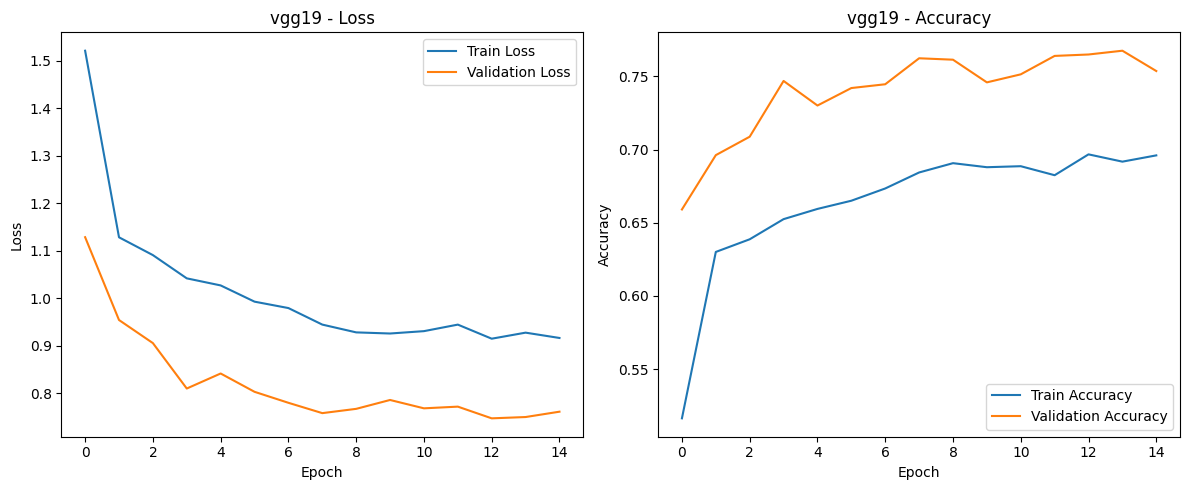


Evaluating vgg19 on validation set:


Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Validation Loss: 0.7741
Validation Accuracy: 0.7452

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.79      0.83      0.81       149
                     Pepper__bell___healthy       0.93      0.90      0.92       224
                      Potato___Early_blight       0.81      0.92      0.86       145
                       Potato___Late_blight       0.78      0.81      0.79       158
                           Potato___healthy       0.43      0.86      0.57        21
                      Tomato_Bacterial_spot       0.75      0.75      0.75       307
                        Tomato_Early_blight       0.61      0.34      0.44       157
                         Tomato_Late_blight       0.81      0.55      0.66       276
                           Tomato_Leaf_Mold       0.66      0.65      0.65       155
                  Tomato_Septoria_leaf_spot       0.67      0.67      0.6

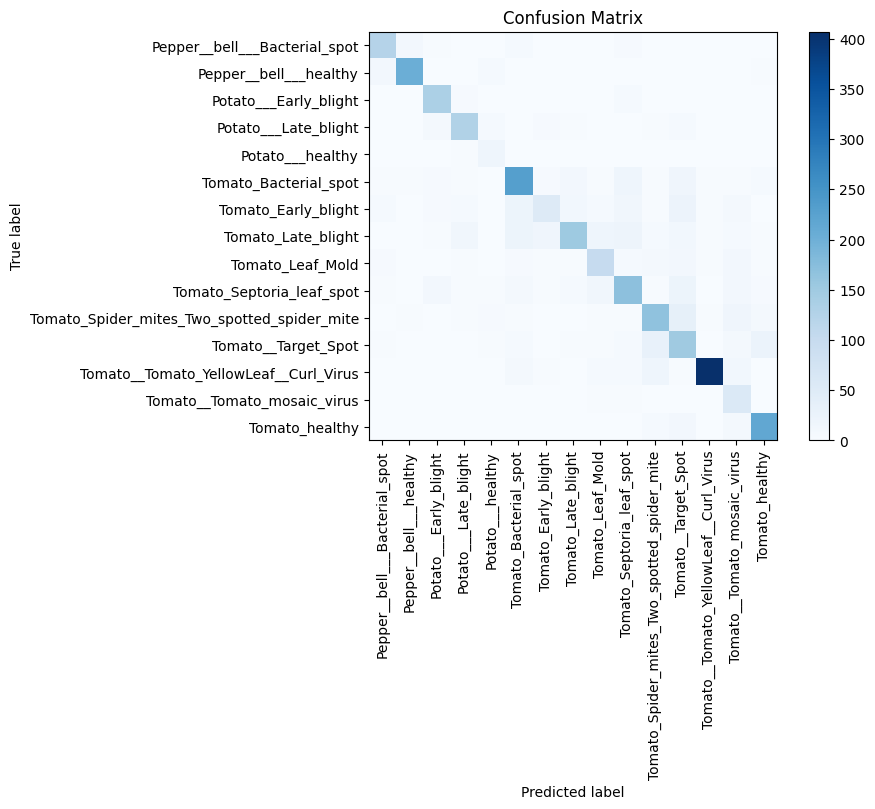


Training resnet34...


Epoch 1/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 1.4220 Acc: 0.6365


Epoch 1/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.9397 Acc: 0.7591
Epoch 1/15 completed in 136s
--------------------------------------------------


Epoch 2/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.7768 Acc: 0.7993


Epoch 2/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.7006 Acc: 0.8021
Epoch 2/15 completed in 134s
--------------------------------------------------


Epoch 3/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.6434 Acc: 0.8211


Epoch 3/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.6002 Acc: 0.8260
Epoch 3/15 completed in 133s
--------------------------------------------------


Epoch 4/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.5706 Acc: 0.8392


Epoch 4/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.5284 Acc: 0.8582
Epoch 4/15 completed in 134s
--------------------------------------------------


Epoch 5/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.5334 Acc: 0.8442


Epoch 5/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.5210 Acc: 0.8531
Epoch 5/15 completed in 133s
--------------------------------------------------


Epoch 6/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.5013 Acc: 0.8509


Epoch 6/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.4846 Acc: 0.8553
Epoch 6/15 completed in 134s
--------------------------------------------------


Epoch 7/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.4766 Acc: 0.8570


Epoch 7/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.4926 Acc: 0.8444
Epoch 7/15 completed in 134s
--------------------------------------------------


Epoch 8/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.4535 Acc: 0.8700


Epoch 8/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.4618 Acc: 0.8618
Epoch 8/15 completed in 137s
--------------------------------------------------


Epoch 9/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.4533 Acc: 0.8659


Epoch 9/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.4559 Acc: 0.8647
Epoch 9/15 completed in 133s
--------------------------------------------------


Epoch 10/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.4496 Acc: 0.8693


Epoch 10/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.4748 Acc: 0.8612
Epoch 10/15 completed in 135s
--------------------------------------------------


Epoch 11/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.4518 Acc: 0.8647


Epoch 11/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.4656 Acc: 0.8602
Epoch 11/15 completed in 135s
--------------------------------------------------


Epoch 12/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.4397 Acc: 0.8719


Epoch 12/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.4705 Acc: 0.8566
Epoch 12/15 completed in 136s
--------------------------------------------------


Epoch 13/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.4420 Acc: 0.8691


Epoch 13/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.4610 Acc: 0.8586
Epoch 13/15 completed in 132s
--------------------------------------------------


Epoch 14/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.4420 Acc: 0.8720


Epoch 14/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.4560 Acc: 0.8637
Epoch 14/15 completed in 137s
--------------------------------------------------


Epoch 15/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.4406 Acc: 0.8713


Epoch 15/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.4609 Acc: 0.8566
Epoch 15/15 completed in 135s
--------------------------------------------------
Model saved to /content/drive/MyDrive/resnet34_complete.pth


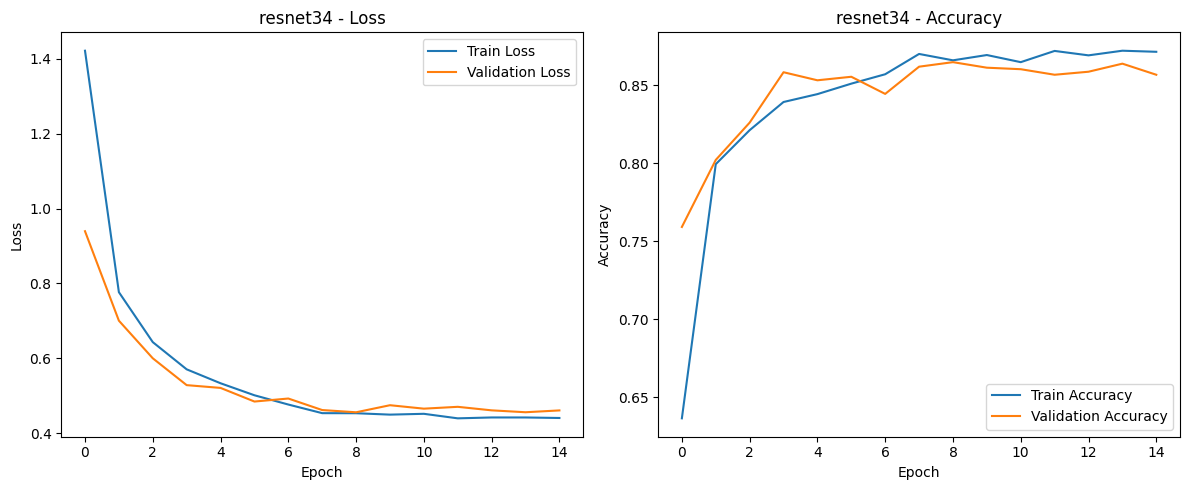


Evaluating resnet34 on validation set:


Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Validation Loss: 0.4641
Validation Accuracy: 0.8566

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.93      0.93      0.93       149
                     Pepper__bell___healthy       0.97      0.96      0.96       224
                      Potato___Early_blight       0.92      0.97      0.95       145
                       Potato___Late_blight       0.90      0.84      0.87       158
                           Potato___healthy       0.77      0.95      0.85        21
                      Tomato_Bacterial_spot       0.84      0.89      0.87       307
                        Tomato_Early_blight       0.63      0.69      0.66       157
                         Tomato_Late_blight       0.88      0.74      0.81       276
                           Tomato_Leaf_Mold       0.74      0.85      0.79       155
                  Tomato_Septoria_leaf_spot       0.83      0.75      0.7

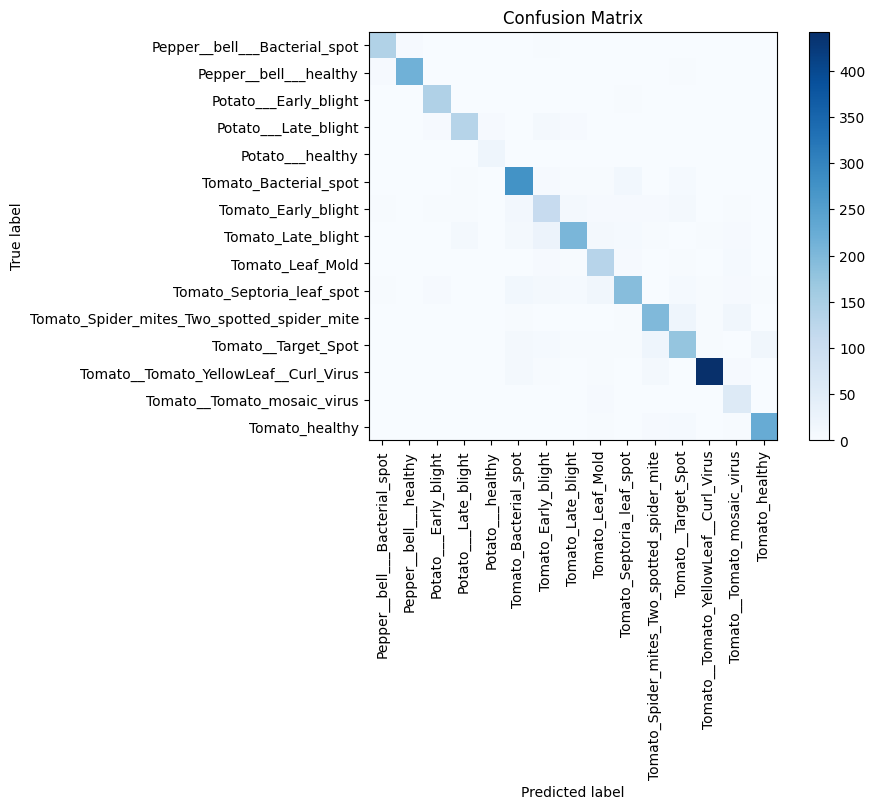


Training densenet121...


Epoch 1/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 1.2497 Acc: 0.7129


Epoch 1/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.7101 Acc: 0.8450
Epoch 1/15 completed in 147s
--------------------------------------------------


Epoch 2/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.5961 Acc: 0.8670


Epoch 2/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.5005 Acc: 0.8860
Epoch 2/15 completed in 143s
--------------------------------------------------


Epoch 3/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.4658 Acc: 0.8864


Epoch 3/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.4284 Acc: 0.8905
Epoch 3/15 completed in 143s
--------------------------------------------------


Epoch 4/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.4208 Acc: 0.8939


Epoch 4/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.3946 Acc: 0.9005
Epoch 4/15 completed in 144s
--------------------------------------------------


Epoch 5/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.3890 Acc: 0.8960


Epoch 5/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.3438 Acc: 0.9119
Epoch 5/15 completed in 146s
--------------------------------------------------


Epoch 6/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.3506 Acc: 0.9085


Epoch 6/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.3207 Acc: 0.9125
Epoch 6/15 completed in 145s
--------------------------------------------------


Epoch 7/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.3286 Acc: 0.9138


Epoch 7/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.3093 Acc: 0.9257
Epoch 7/15 completed in 144s
--------------------------------------------------


Epoch 8/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.3194 Acc: 0.9132


Epoch 8/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.3144 Acc: 0.9209
Epoch 8/15 completed in 145s
--------------------------------------------------


Epoch 9/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.3053 Acc: 0.9191


Epoch 9/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.3137 Acc: 0.9144
Epoch 9/15 completed in 144s
--------------------------------------------------


Epoch 10/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.3057 Acc: 0.9166


Epoch 10/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.3107 Acc: 0.9167
Epoch 10/15 completed in 147s
--------------------------------------------------


Epoch 11/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.3025 Acc: 0.9180


Epoch 11/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.2924 Acc: 0.9261
Epoch 11/15 completed in 146s
--------------------------------------------------


Epoch 12/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.2995 Acc: 0.9216


Epoch 12/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.3067 Acc: 0.9202
Epoch 12/15 completed in 146s
--------------------------------------------------


Epoch 13/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.3057 Acc: 0.9193


Epoch 13/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.3004 Acc: 0.9264
Epoch 13/15 completed in 145s
--------------------------------------------------


Epoch 14/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.2987 Acc: 0.9196


Epoch 14/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.3013 Acc: 0.9135
Epoch 14/15 completed in 148s
--------------------------------------------------


Epoch 15/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.2987 Acc: 0.9227


Epoch 15/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.3045 Acc: 0.9219
Epoch 15/15 completed in 145s
--------------------------------------------------
Model saved to /content/drive/MyDrive/densenet121_complete.pth


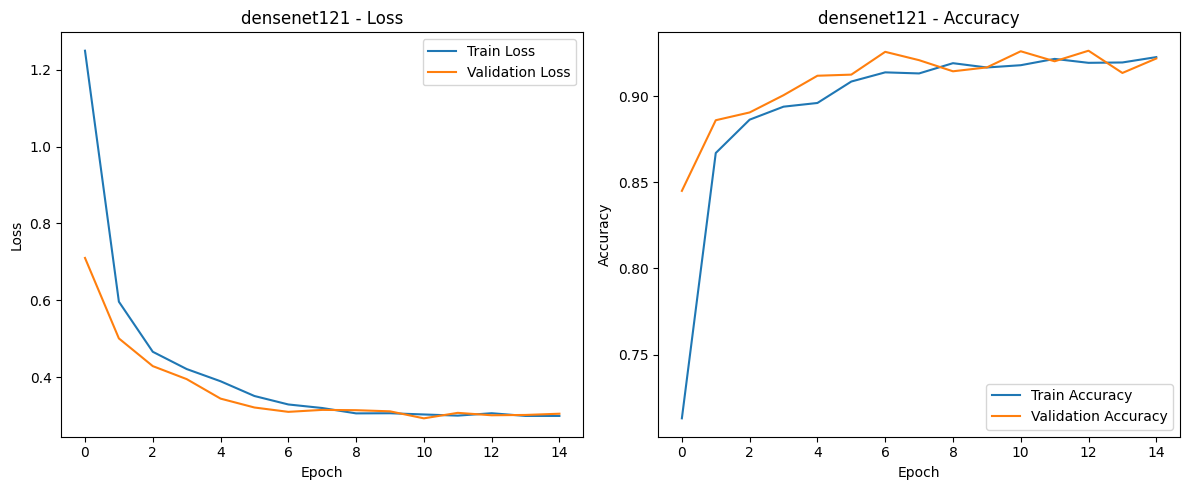


Evaluating densenet121 on validation set:


Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Validation Loss: 0.3097
Validation Accuracy: 0.9173

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.95      0.97      0.96       149
                     Pepper__bell___healthy       0.99      0.98      0.98       224
                      Potato___Early_blight       0.94      1.00      0.97       145
                       Potato___Late_blight       0.91      0.92      0.92       158
                           Potato___healthy       0.81      1.00      0.89        21
                      Tomato_Bacterial_spot       0.89      0.93      0.91       307
                        Tomato_Early_blight       0.77      0.81      0.79       157
                         Tomato_Late_blight       0.91      0.85      0.88       276
                           Tomato_Leaf_Mold       0.87      0.89      0.88       155
                  Tomato_Septoria_leaf_spot       0.91      0.85      0.8

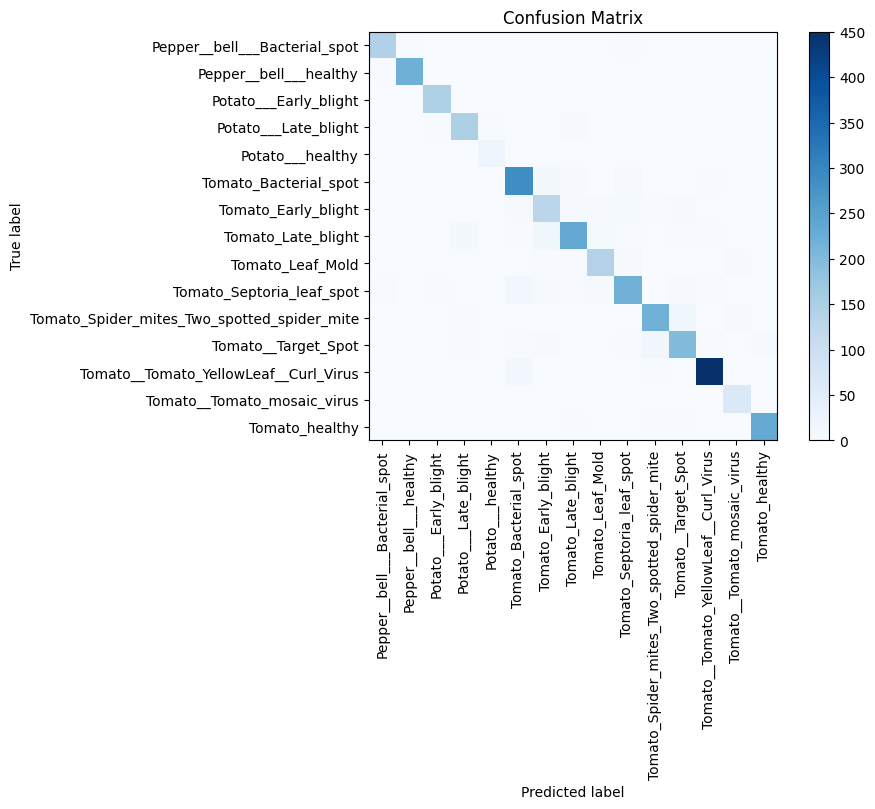

Model Comparison:


,Model,Val Accuracy,Val Loss,Training Time
0,vgg19,0.7675,0.7474,2755.1550092697144
1,resnet34,0.8647,0.4559,2016.7957952022552
2,densenet121,0.9264,0.2924,2177.1796913146973


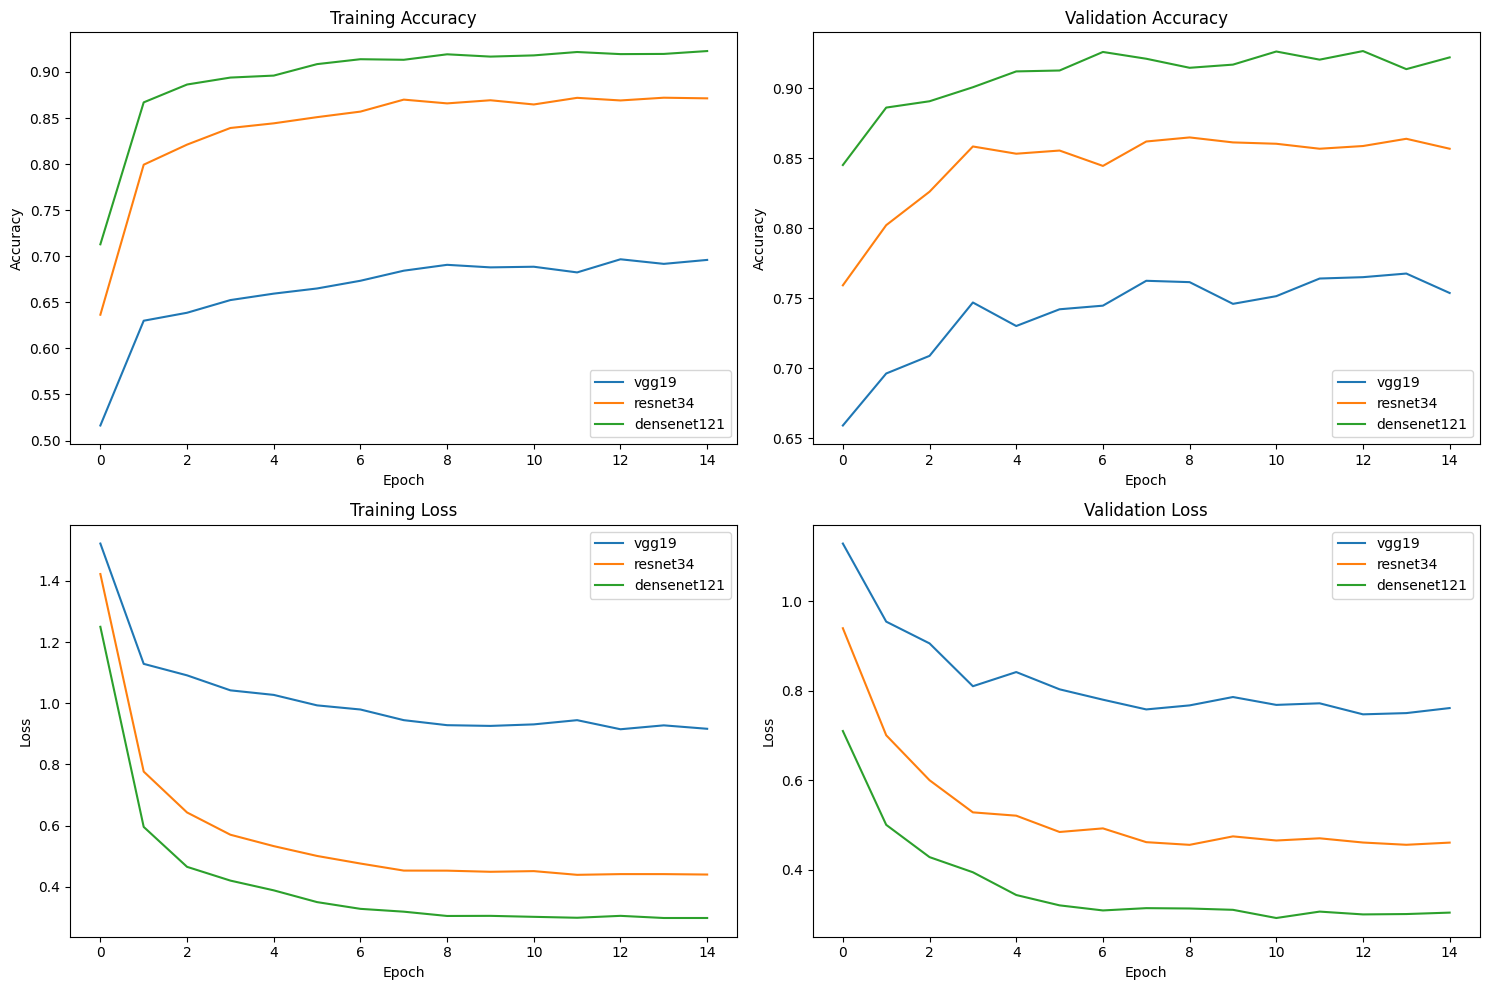

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: T

<Figure size 1500x1000 with 0 Axes>

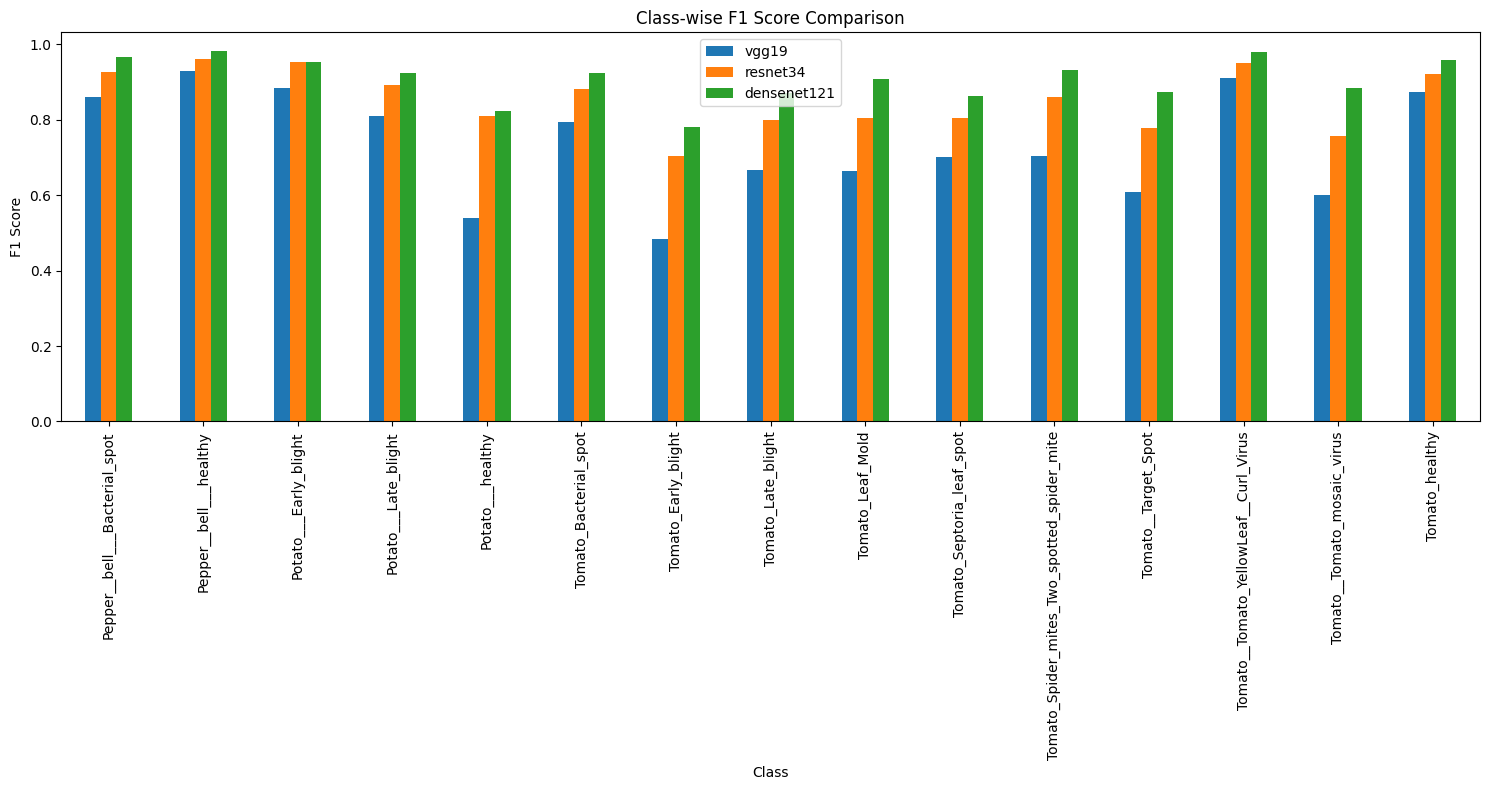


Best performing model: densenet121 with accuracy: 0.9264
Model saved to /content/drive/MyDrive/densenet121_best_complete.pth

Training a model from scratch for comparison...


Epoch 1/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 1.8140 Acc: 0.4065


Epoch 1/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 1.0422 Acc: 0.6522
Epoch 1/15 completed in 148s
--------------------------------------------------


Epoch 2/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 1.2389 Acc: 0.5927


Epoch 2/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 1.0053 Acc: 0.6626
Epoch 2/15 completed in 150s
--------------------------------------------------


Epoch 3/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.9854 Acc: 0.6836


Epoch 3/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.7194 Acc: 0.7688
Epoch 3/15 completed in 147s
--------------------------------------------------


Epoch 4/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.8086 Acc: 0.7403


Epoch 4/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.7871 Acc: 0.7543
Epoch 4/15 completed in 148s
--------------------------------------------------


Epoch 5/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.7842 Acc: 0.7473


Epoch 5/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.4936 Acc: 0.8369
Epoch 5/15 completed in 147s
--------------------------------------------------


Epoch 6/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.6339 Acc: 0.7986


Epoch 6/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.5473 Acc: 0.8247
Epoch 6/15 completed in 149s
--------------------------------------------------


Epoch 7/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.5420 Acc: 0.8243


Epoch 7/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.4439 Acc: 0.8553
Epoch 7/15 completed in 147s
--------------------------------------------------


Epoch 8/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.3198 Acc: 0.8956


Epoch 8/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.2296 Acc: 0.9232
Epoch 8/15 completed in 149s
--------------------------------------------------


Epoch 9/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.2682 Acc: 0.9119


Epoch 9/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.2074 Acc: 0.9351
Epoch 9/15 completed in 148s
--------------------------------------------------


Epoch 10/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.2358 Acc: 0.9227


Epoch 10/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.1777 Acc: 0.9403
Epoch 10/15 completed in 147s
--------------------------------------------------


Epoch 11/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.2097 Acc: 0.9283


Epoch 11/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.1918 Acc: 0.9422
Epoch 11/15 completed in 147s
--------------------------------------------------


Epoch 12/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.1953 Acc: 0.9360


Epoch 12/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.1739 Acc: 0.9487
Epoch 12/15 completed in 146s
--------------------------------------------------


Epoch 13/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.2025 Acc: 0.9335


Epoch 13/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.1748 Acc: 0.9477
Epoch 13/15 completed in 148s
--------------------------------------------------


Epoch 14/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.1843 Acc: 0.9366


Epoch 14/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.1782 Acc: 0.9480
Epoch 14/15 completed in 146s
--------------------------------------------------


Epoch 15/15 - train:   0%|          | 0/452 [00:00<?, ?it/s]

train Loss: 0.1706 Acc: 0.9415


Epoch 15/15 - valid:   0%|          | 0/97 [00:00<?, ?it/s]

valid Loss: 0.1553 Acc: 0.9529
Epoch 15/15 completed in 149s
--------------------------------------------------


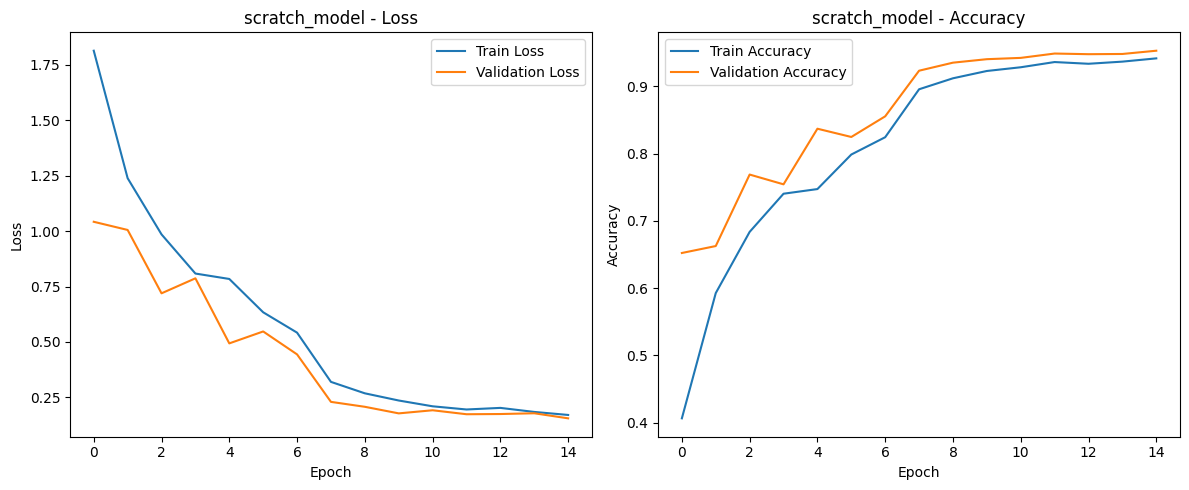


Evaluating scratch model on validation set:


Evaluating:   0%|          | 0/97 [00:00<?, ?it/s]

Validation Loss: 0.1616
Validation Accuracy: 0.9529

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.96      0.92      0.94       149
                     Pepper__bell___healthy       0.98      0.99      0.98       224
                      Potato___Early_blight       0.98      0.98      0.98       145
                       Potato___Late_blight       0.92      0.93      0.93       158
                           Potato___healthy       0.84      1.00      0.91        21
                      Tomato_Bacterial_spot       0.95      0.97      0.96       307
                        Tomato_Early_blight       0.93      0.90      0.92       157
                         Tomato_Late_blight       0.93      0.91      0.92       276
                           Tomato_Leaf_Mold       0.96      0.95      0.96       155
                  Tomato_Septoria_leaf_spot       0.91      0.95      0.9

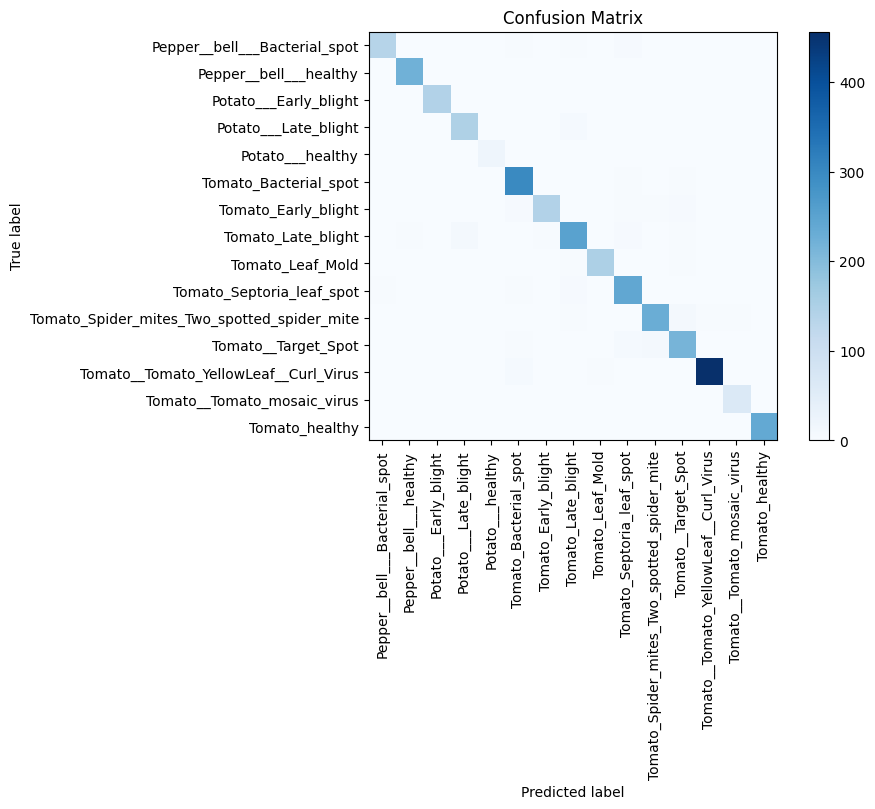


All model training completed successfully!


In [ ]:
# Main execution block
try:
    # Train the transfer learning models
    train_all_models()

    # Train a model from scratch for comparison
    train_from_scratch()

    print("\nAll model training completed successfully!")

except Exception as e:
    print(f"An error occurred during model training: {str(e)}")
    import traceback
    traceback.print_exc()